In [1]:
"""
Cel:
- predykcja na 1 dzien/10dni/20dni w przod

Preprocessing:
- skalowanie
- smuding
Modele:
- sarima
- xgboost
- LSTM
- RNN
Korzystajac z danych:
- dla 1 banku
- dla kilku bankow
Wspomaganie:
- bayesowski tuning hyperparametrow
- rozne okna wejsciowe i wyjsciowe


porownac na rozne oknca czasowe, ktore dobrena 1 dzien ktore na wiele dni
recenzja biezacego etapu prac

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-1-524271795e75>, line 21)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping

import datetime as dt

C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header

In [3]:
# SCALERS = StandardScaler, RobustScaler, MinMaxScaler
SCALER = MinMaxScaler()
# DATASETS = USA, GERMANY, BRASIL, NETHERLANDS
DATASET = "NETHERLANDS.csv"
PLOT_DATA = True
n_of_predictions =4
INPUT_TIME_STEPS=10
OUTPUT_TIME_STEPS=5
STATEFUL=False


def plot_share_prices_over_time(timestamps, share_prices, title):
    plt.figure(figsize=(12,8))
    plt.plot(timestamps, share_prices)
    plt.grid()
    plt.legend([DATASET[:-4]])
    plt.title(title)

In [15]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

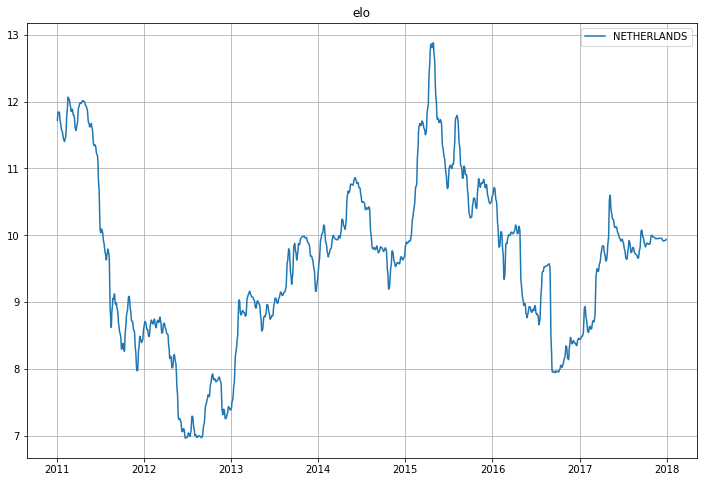

In [24]:

from pylab import *


smoothed_share_prices = smooth(share_prices, 10)
plot_share_prices_over_time(timestamps, smoothed_share_prices[:1790], 'elo')

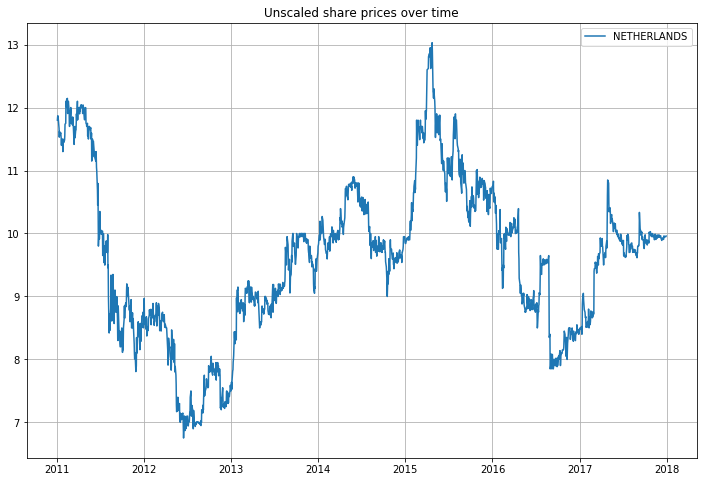

In [9]:
def load_data(file_name, start_date = "2011-01-01", end_date = "2017-12-31", plot_data=True):
    data = pd.read_csv("C:/Users/OPTIMUSPRIME/Desktop/Studia/Eksploracja danych/Project/" + file_name)
    data.fillna(0, inplace=True)
    data_trimmed = data[(data["Date"] > start_date) & (data["Date"] < end_date)]
    
    share_prices = np.array(data_trimmed.values[:,1])
    timestamps = np.array([dt.datetime.strptime(d, '%Y-%m-%d').date() for d in data_trimmed.values[:, 0]])
    
    if plot_data:
        plot_share_prices_over_time(timestamps, share_prices, title="Unscaled share prices over time")
    return share_prices, timestamps

share_prices, timestamps = load_data(file_name=DATASET, plot_data=True)

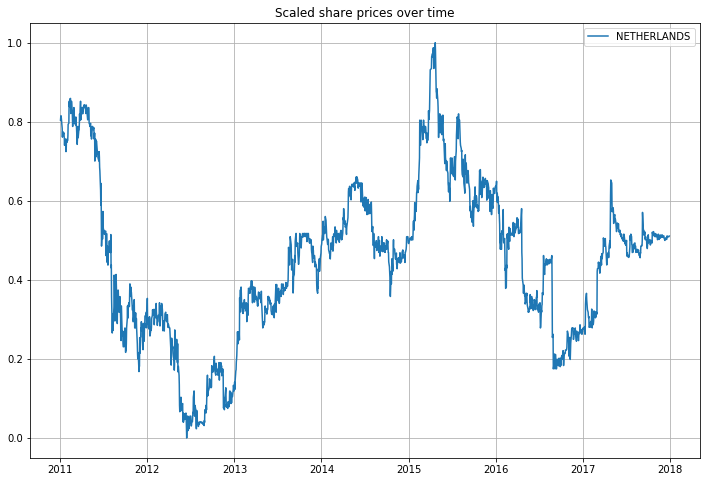

In [4]:
def scale_data(share_prices, plot_data):
    scaled_share_prices = SCALER.fit_transform(share_prices.reshape(-1,1)).reshape(1, -1)[0] 
    if plot_data:
        plot_share_prices_over_time(timestamps, scaled_share_prices, title="Scaled share prices over time")
    return scaled_share_prices
    
scaled_share_prices = scale_data(share_prices, plot_data=True)

In [6]:
def series_to_supervised(share_prices, timestamps, input_time_steps, output_time_steps, dropnan=True):
    share_prices_df = pd.DataFrame(share_prices)
    timestamps_df = pd.DataFrame(timestamps)
    share_prices_timeseries = list()
    timestamps_timeseries = list()
    
    for i in range(input_time_steps, 0, -1):
        share_prices_timeseries.append(share_prices_df.shift(i))
        timestamps_timeseries.append(timestamps_df.shift(i))
    for i in range(0, output_time_steps):
        share_prices_timeseries.append(share_prices_df.shift(-i))
        timestamps_timeseries.append(timestamps_df.shift(-i))
    
    aggregated_share_prices = pd.concat(share_prices_timeseries, axis=1)
    aggregated_timestamps = pd.concat(timestamps_timeseries, axis=1)
    
    if dropnan:
        aggregated_share_prices.dropna(inplace=True)
        aggregated_timestamps.dropna(inplace=True)

    aggregated_timestamps = aggregated_timestamps.values
    aggregated_share_prices = aggregated_share_prices.values
    
    not_overlapping_indexes = range(0, 
                                    len(aggregated_share_prices) - (output_time_steps - 1 + input_time_steps), 
                                    output_time_steps)
    
    aggregated_timestamps = aggregated_timestamps[not_overlapping_indexes]
    aggregated_share_prices = aggregated_share_prices[not_overlapping_indexes]
    
    return aggregated_share_prices, aggregated_timestamps

transformed_share_prices, transformed_timestamps = series_to_supervised(scaled_share_prices,timestamps,INPUT_TIME_STEPS, OUTPUT_TIME_STEPS)
n_samples = len(transformed_share_prices)
print(f"Number of samples: {n_samples}")
train = transformed_share_prices[: int(0.95 * n_samples)]
test = transformed_share_prices[int(0.95 * n_samples) :]
test_timestamps = transformed_timestamps[int(0.95 * n_samples) :]

NameError: name 'scaled_share_prices' is not defined

In [12]:
def fit_lstm(train_data, input_time_steps, batch_size, epochs, neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:input_time_steps], train[:, input_time_steps:]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    # design network
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=STATEFUL))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    # fit network
    
    if STATEFUL:        
        for i in range(epochs):
            print(f"Epoch {i+1}")
            model.fit(X, y, 
                      epochs=1, 
                      batch_size=batch_size, 
                      verbose=1, 
                      shuffle=False)
            model.reset_states()
    else:
        model.fit(X, y, 
                  epochs=epochs, 
                  batch_size=batch_size, 
                  verbose=1, 
                  shuffle=False, 
                  callbacks=[EarlyStopping(min_delta=0.001, patience=10, monitor='loss')])
                   
    return model

model = fit_lstm(train, input_time_steps=INPUT_TIME_STEPS, batch_size=1, epochs=50, neurons=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (1, 128)                  66560     
_________________________________________________________________
dense_4 (Dense)              (1, 5)                    645       
Total params: 67,205
Trainable params: 67,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
335/335 [==============================] - 3s 8ms/step - loss: 0.0174
Epoch 2/50
335/335 [==============================] - 2s 6ms/step - loss: 0.0054
Epoch 3/50
335/335 [==============================] - 2s 6ms/step - loss: 0.0066
Epoch 4/50
335/335 [==============================] - 2s 6ms/step - loss: 0.0085
Epoch 5/50
335/335 [==============================] - 2s 6ms/step - loss: 0.0103
Epoch 6/50
335/335 [==============================] - 2s 6ms/step - loss: 0.0115
Epoch 7/50
335/335 [============================

In [9]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, batch_size):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, X.shape[0], 1)
    # make forecast
    forecast = model.predict(X, batch_size=batch_size)
    # convert to array
    return forecast[0]

# evaluate the persistence model
def make_forecasts(model, batch_size, test, n_of_predictions, input_time_steps, output_time_steps):
    forecasts = np.array([])
    X = test[0, 0:input_time_steps]
    for i in range(n_of_predictions):
        forecast = forecast_lstm(model, X, batch_size)
        forecasts = np.append(forecasts, forecast)
        if input_time_steps == output_time_steps:
            X = forecast
        else:
            X = np.append(X[-input_time_steps+output_time_steps:], forecast)
    
    return SCALER.inverse_transform(forecasts.reshape(-1,1)).reshape(1, -1)[0]


In [10]:
predicted_share_prices = make_forecasts(model, 1, test, n_of_predictions, INPUT_TIME_STEPS, OUTPUT_TIME_STEPS)

Text(0.5, 0, 'Timestamps')

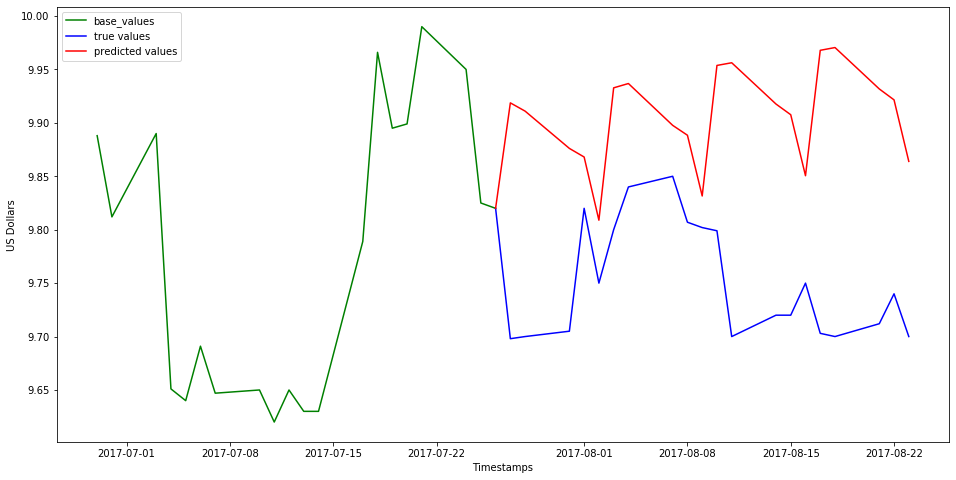

In [11]:
first_predicted_index = np.where(timestamps == test_timestamps[0,0])[0][0]

base_timestamps_for_prediction = timestamps[first_predicted_index-15 : first_predicted_index + OUTPUT_TIME_STEPS] 
base_share_prices_for_prediction = share_prices[first_predicted_index-15 : first_predicted_index + OUTPUT_TIME_STEPS]

timestamps_during_prediction = timestamps[first_predicted_index + OUTPUT_TIME_STEPS - 1 : first_predicted_index + OUTPUT_TIME_STEPS * (n_of_predictions + 1)]
actual_share_prices_connected = share_prices[first_predicted_index + OUTPUT_TIME_STEPS - 1 : first_predicted_index + OUTPUT_TIME_STEPS * (n_of_predictions + 1)]

predicted_share_prices_connected = np.concatenate((np.array([base_share_prices_for_prediction[-1]]), predicted_share_prices))

plt.figure(figsize=(16,8))
plt.plot(base_timestamps_for_prediction, base_share_prices_for_prediction, c='g', label='base_values')
plt.plot(timestamps_during_prediction, actual_share_prices_connected, color='b', label='true values')
plt.plot(timestamps_during_prediction, predicted_share_prices_connected, color='r', label='predicted values')
plt.legend(loc='best')
plt.ylabel("US Dollars")
plt.xlabel("Timestamps")
# plt.savefig(f"LSTMStateless_50epoch_10neurons_INPUT{INPUT_TIME_STEPS}_OUTPUT{OUTPUT_TIME_STEPS}_20110101_20171231_train95_test05_{n_of_predictions}predictions")